In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
import torch.nn.functional as F
import torchvision
from time import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Parts of the code based on https://www.youtube.com/watch?v=a4Yfz2FxXiY

In [2]:
batch_size = 64
num_workers = 4
H, W = 64, 64

dataset = torchvision.datasets.CelebA(root=".\data", download=False, split = "train", transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                                torchvision.transforms.Resize((H,W)),
                                                                                                                torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
dataloader = torch.utils.data.DataLoader(dataset,shuffle=True,num_workers=num_workers,batch_size=batch_size,pin_memory=True,drop_last=True)


### How to combine time-step and images?
<img src="ImageTimeAddition.png" alt="drawing" width="650"/>


This picture assumes images with 3 channels. Note that each time-vector needs to have the same length as an image has channels. So if our starting time-embedding space is 32-dimensional, but our image-embedding has 64 channels, we use nn.Linear(32, 64) to upsample time-embedding s.t. they match. Each image channel is assigned a number of the time vector. The number is added to each pixel of the channel. 

#### Positional Encoding:
https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

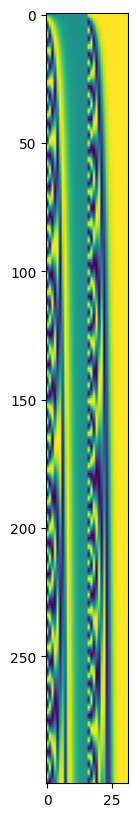

In [4]:
position_embedding = SinusoidalPositionEmbeddings(32)  # Dim of time-embedding
time_embedding = torch.tensor([i for i in range(300)])  # 0 -> T
plt.figure(figsize=(12,10))
plt.imshow(position_embedding(time_embedding))
plt.show()

In [5]:
class U_Block(nn.Module):
    """
    Creates one block in U-Net.
    Each Block consists of:
    1. First Convolution: Varying for Up-/Downsampling. In Downsampling the image height/width be halved, In Upsampling maintained (And there is the double number of input-channels which enables Residual Connections).
    2. Time Embedding: Simple Linear Layer followed by an activation function.
    3. Adding outputs: Adding outputs of first Convolution and Time Embedding, see figure above
    4. Second Convolution: Standard Convolution, the same independent if Up- or Downsampling
    5. Transformation: In order to sample the image Down/Up, it's needed Convolution for Downsampling and TransposedConvolution for Upsampling. Downsampling halves the Height/Width, Upsampling doubles it 
    """
    def __init__(self, channels_in, channels_out, time_dim, downsampling) -> None:
        """
        :param channels_in: Number of input channels
        :param channels_out: Number of output channels
        :param time_dim: Input dimension of time embedding
        :param downsampling: Bool if downsampling or upsampling
        :param activation: activation function to use
        """        
        super().__init__()
        
        self.time_projection = nn.Linear(time_dim, channels_out)

        if downsampling:
            self.conv1 = nn.Conv2d(channels_in, channels_out, 3, padding=1)
            self.transformation = nn.Conv2d(channels_out, channels_out, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(2*channels_in, channels_out, 3, padding=1)
            self.transformation = nn.ConvTranspose2d(channels_out, channels_out, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(channels_out, channels_out, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels_out)
        self.bn2 = nn.BatchNorm2d(channels_out)
        self.activation = nn.ReLU()

    def forward(self, x, t):
        """
        Forward path of U-Block
        """
        # First Convolution
        x = self.bn1(self.activation(self.conv1(x)))

        # Time Embedding
        time_projection = self.activation(self.time_projection(t))
        time_projection = time_projection[:, :, None, None]

        # Adding X and Time
        x = x + time_projection

        # Second Convolution
        x = self.bn2(self.activation(self.conv2(x)))
        
        # Transformation
        x = self.transformation(x)

        return x

In [6]:
class U_Net(nn.Module):
    """
    pass
    """
    def __init__(self) -> None:
        super().__init__()

        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        time_embedding_dim = 32

        # self.activation = activation_function

        # Time embedding
        self.time_projection = nn.Sequential(
                SinusoidalPositionEmbeddings(time_embedding_dim),
                nn.Linear(time_embedding_dim, time_embedding_dim),
                nn.ReLU()
            )
        
        # Initial Projection
        self.conv0 = nn.Conv2d(3, down_channels[0], 3, padding=1)

        # Downsampling
        self.downsampling = nn.ModuleList([U_Block(down_channels[i], down_channels[i+1], time_embedding_dim, True) for i in range(len(down_channels)-1)])

        # Upsampling
        self.upsampling = nn.ModuleList([U_Block(up_channels[i], up_channels[i+1], time_embedding_dim, False) for i in range(len(up_channels)-1)])

        # Output
        self.output = nn.Conv2d(up_channels[-1], 3, 1)

    def forward(self, x, timestep):
        """
        pass
        """
        residuals = []

        # Time Embedding
        t = self.time_projection(timestep)

        # Initial Convolution
        x = self.conv0(x)

        # Downsampling
        for down in self.downsampling:
            x = down(x, t)
            residuals.append(x)
        
        # Upsampling
        for up in self.upsampling:
            residual = residuals.pop()
            x = torch.cat((x, residual), dim = 1)
            x = up(x, t)

        return self.output(x)

In [7]:
model = U_Net().to(device)
summary(model, input_size=((batch_size, 3, H, W), (batch_size, )))

Layer (type:depth-idx)                        Output Shape              Param #
U_Net                                         [64, 3, 64, 64]           --
├─Sequential: 1-1                             [64, 32]                  --
│    └─SinusoidalPositionEmbeddings: 2-1      [64, 32]                  --
│    └─Linear: 2-2                            [64, 32]                  1,056
│    └─ReLU: 2-3                              [64, 32]                  --
├─Conv2d: 1-2                                 [64, 64, 64, 64]          1,792
├─ModuleList: 1-3                             --                        --
│    └─U_Block: 2-4                           [64, 128, 32, 32]         --
│    │    └─Conv2d: 3-1                       [64, 128, 64, 64]         73,856
│    │    └─ReLU: 3-2                         [64, 128, 64, 64]         --
│    │    └─BatchNorm2d: 3-3                  [64, 128, 64, 64]         256
│    │    └─Linear: 3-4                       [64, 128]                 4,224
│    │

In [8]:
T = 300  # Number of timesteps
beta = torch.linspace(0.0001, 0.02, T, device=device)
alpha = 1 - beta

alpha_bar = torch.cumprod(alpha, dim = 0)
alpha_bar_prev = F.pad(alpha_bar[:-1], (1, 0), value=1.0)

sqrt_inv_alpha = torch.sqrt(1.0 / alpha)
sqrt_alpha_bar = torch.sqrt(alpha_bar)

sqrt_one_minus_alpha_bar = torch.sqrt(1. - alpha_bar)
posterior_variance = beta * (1. - alpha_bar_prev) / (1. - alpha_bar)

### Forward process:

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, \sqrt{(1-\bar\alpha_t)} \mathbf{I} \Big)
\end{align}

Following the algorithm:

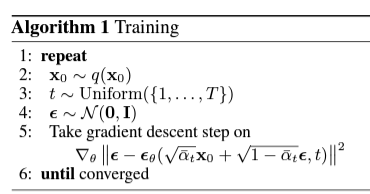

Note that we can use the reparameterization trick: $q(x_t|x_0) = \sqrt{\bar\alpha_t} x_0+\sqrt{(1-\bar\alpha_t)}*\mathcal{N}(0,1)$

https://arxiv.org/pdf/2006.11239.pdf

In [9]:
def q_xt_x0(x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Computes x_t (=noisy version of x_0) dependent on time-steps t and x0. Each image of x_0 gets noisy dependent on its own time-step in t.
    :param x0: Batch of image-data, shape (batch_size, 3, H, W)
    :param noise: White noise, same shape as x0
    :param t: Tensor of timesteps, shape (t) NOT ENCODED
    :returns: Noisy version of x_0, same shape as x0
    """
    mean = torch.sqrt(alpha_bar[t])[:, None, None, None]  # Expand dimension of alphar_bar for broadcasting, multiply each pixel-value of ONE image by the same float.
    var = torch.sqrt(1-alpha_bar[t])[:, None, None, None]
    noise = torch.randn_like(x_0)

    return mean*x_0 + var*noise, noise

Text(0.5, 1.0, 'Weighting of Mean and Variance in Forward process')

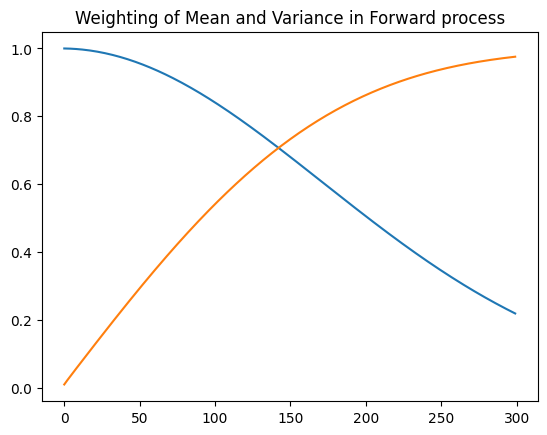

In [11]:
plt.plot(range(T), torch.sqrt(alpha_bar).cpu())
plt.plot(range(T), torch.sqrt(1-alpha_bar).cpu())
plt.title("Weighting of Mean and Variance in Forward process")

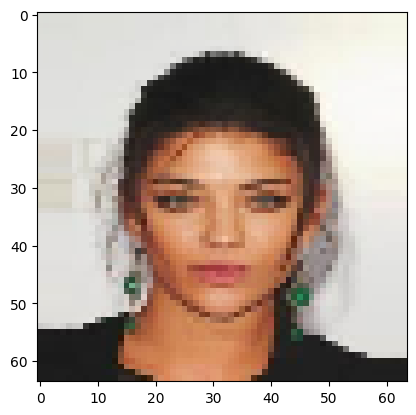

In [12]:
test_images = next(iter(dataloader))[0]
plt.imshow(test_images[0].permute(1,2,0)*0.5+0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


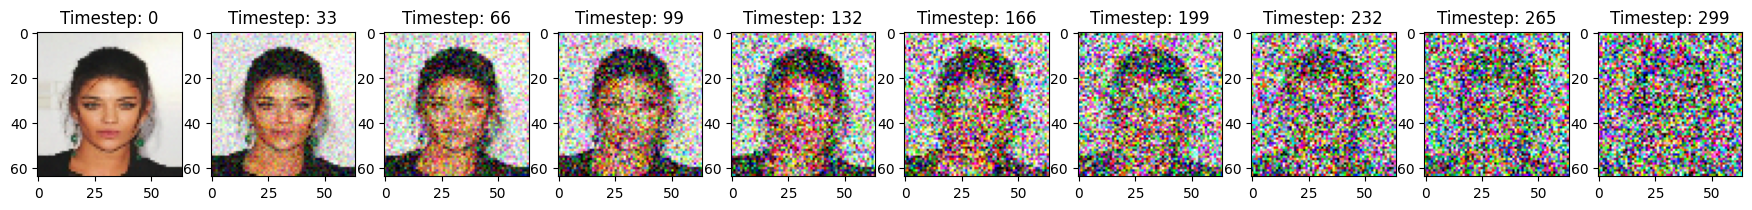

In [13]:
noisy_images = []
test_image_batch = test_images.to(device)
timesteps = torch.linspace(0,T-1,10, dtype=torch.int, device=device)  # Plot 10 Timesteps

for i in timesteps:
    i = torch.full((batch_size, ), i)
    noisy_images.append(q_xt_x0(test_image_batch, i)[0][0].cpu())

_, axs = plt.subplots(1, 10, figsize=(22, 22))
axs = axs.flatten()
for t, img, ax in zip(timesteps, noisy_images, axs):
    ax.imshow(img.permute(1,2,0)*0.5+0.5)  # denormalization
    ax.set_title(f"Timestep: {t.item()}")
plt.show()

### Reverse process

\begin{align}
 \textcolor{lightgreen}{\epsilon_\theta}(x_t, t) &= \text{Neural Networks prediction whats noise}\\
\textcolor{lightgreen}{\mu_\theta}
  &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
    \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\textcolor{lightgreen}{\epsilon_\theta}(x_t, t) \Big)\\

    \textcolor{lightgreen}{p_\theta}(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
\textcolor{lightgreen}{\mu_\theta}, \sigma_t^2 \mathbf{I} \big)\\
\sigma_t^2 &= \beta_t \frac{1-\bar\alpha_{t-1}}{1-\bar\alpha_t}
\end{align}

1. Our neural net is $\epsilon_\theta$, predicting the noise between $x_t$ and $x_0$ by only seeing $x_t$. For performance reason, we dont want to predict one-shot a new $x_0$; the better approach is to predict an image iterative, T times.
2. Substract the predicted noise from $x_t$ (in a weighted way).
3. Using the result from the step before as mean, we add noise to the prediction (since our model predicts the noise between $x_0$ and $x_t$, not between $x_{t-1}$ and $x_t$)
4. There are different ways to define $\sigma_t^2$, and it is also possible to learn it in a way as we learn $\mu$. Another way is: $\sigma_t^2=\beta_t$


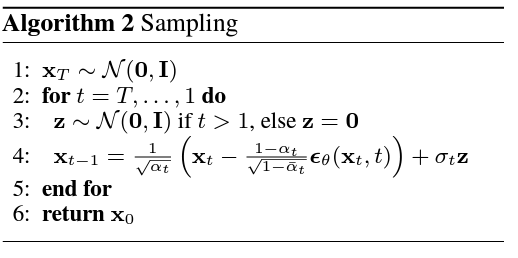

Note that $1-\alpha_t = \beta_t$, so it is the same equation as above. Also note that we need to compute the square-root of $\sigma_t^2$ for sampling.

In [14]:
@torch.no_grad()
def p_xt1_xt(xt: torch.Tensor, t: torch.Tensor, alpha_bar: torch.Tensor = alpha_bar, alpha: torch.Tensor = alpha, beta: torch.Tensor = beta) -> torch.Tensor:
    """
    Estimates x_t-1 (less noisy version of x_t) dependent on time-step t and xt using NN.
    :param xt: Noisy image, shape (3, H, W)
    :param t: time-step
    :returns: Less noisy image, same shape as xt
    """
    beta_t = beta[t][:, None, None, None]
    sqrt_inv_alpha_t = sqrt_inv_alpha[t][:, None, None, None]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar[t][:, None, None, None]

    mean = sqrt_inv_alpha_t*(xt-beta_t*model(xt, t)/sqrt_one_minus_alpha_bar_t)

    if t == 0:
        return mean
    else:
        var = posterior_variance[t][:, None, None, None]
        noise = torch.randn_like(xt)
        return mean + torch.sqrt(var) * noise

In [15]:
def p_x0_xT(T: int, H: int = H, W: int = W) -> torch.Tensor:
    """
    Computes p(x0|xT) where xT is just Gaussian Noise.
    :param T: Number of timesteps used for train the model
    :param H: Height of image
    :param W: Width of image
    :returns: Generated Image
    """
    
    image = torch.randn((1,3,H,W), device = device)
    for i in reversed(range(T)):
        t = torch.tensor([i], device=device, dtype=torch.long)
        image = p_xt1_xt(image, t)
    return image

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 3
loss_hist = []

100%|██████████| 2543/2543 [21:23<00:00,  1.98 batch/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 2543/2543 [23:50<00:00,  1.78 batch/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
100%|██████████| 2543/2543 [27:07<00:00,  1.56 batch/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


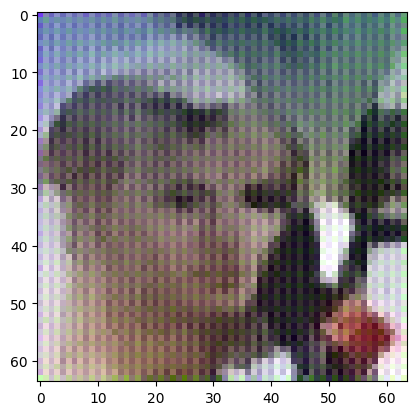

In [17]:
for epoch in range(1, epochs + 1):
    with tqdm(dataloader, unit=" batch") as loader:
        model.train()
        for x_0 in loader:
            x_0 = x_0[0].to(device)
            optimizer.zero_grad()
            t = torch.randint(0, T, (len(x_0),), device=device).long()
            x_t, noise = q_xt_x0(x_0, t)
            pred_noise = model(x_t, t)
            loss = F.l1_loss(pred_noise, noise)
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            del pred_noise, x_t, t, noise

    # model.eval()
    image = p_x0_xT(T).cpu()
    image = (image*0.5)+0.5  # Undo normalization
    image = image[0]
    image = image.squeeze().permute(1, 2, 0)
    plt.imshow(image)

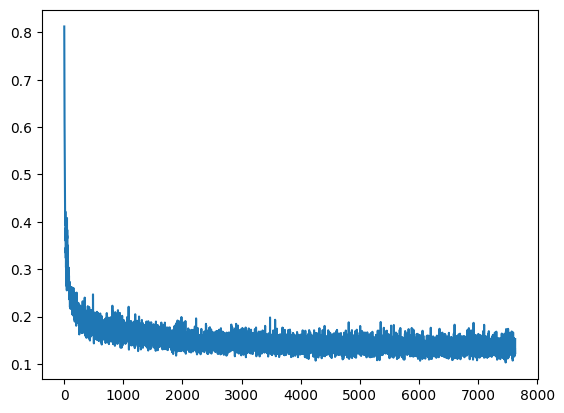

In [18]:
plt.plot(range(len(loss_hist)), loss_hist)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


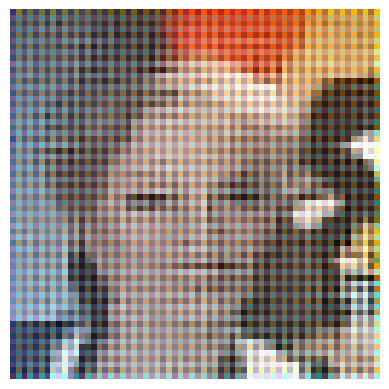

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


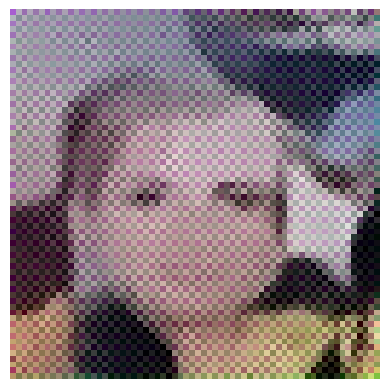

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


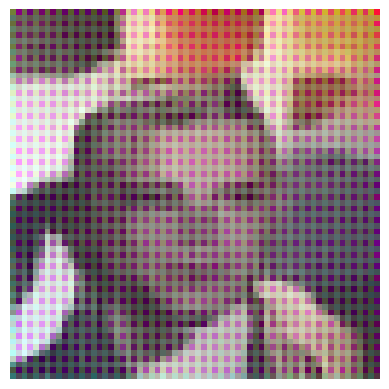

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


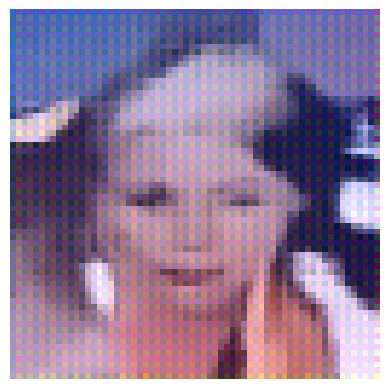

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


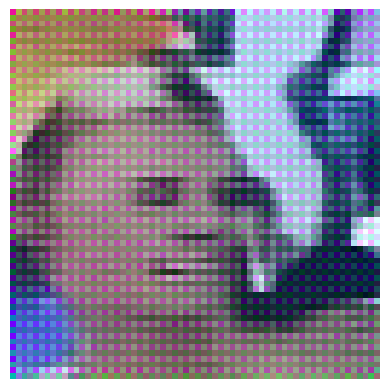

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


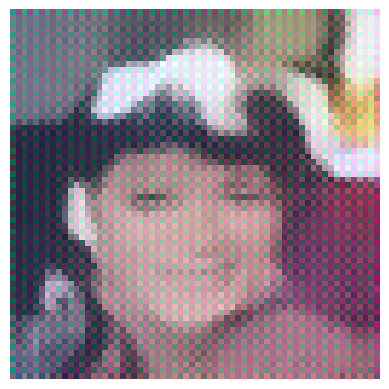

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


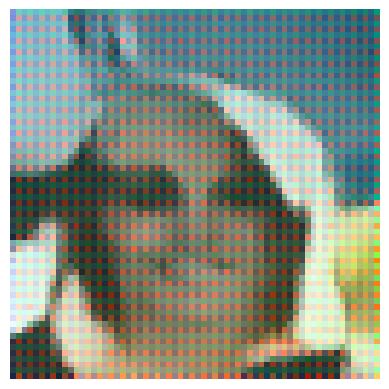

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


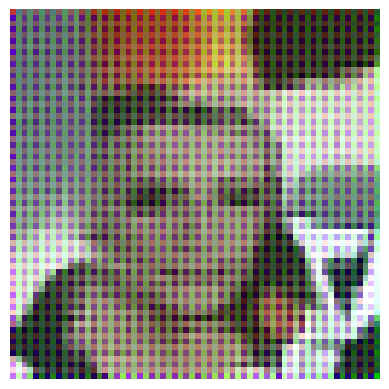

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


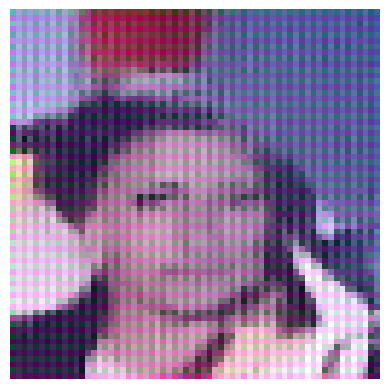

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


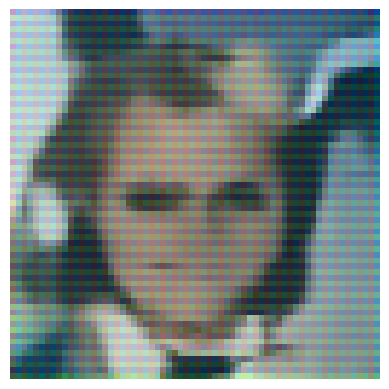

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


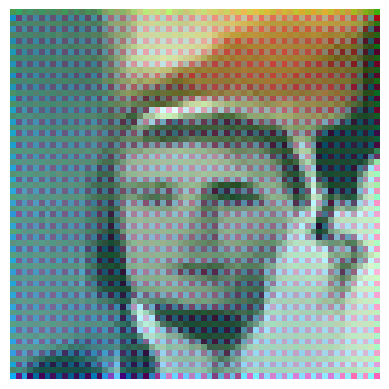

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


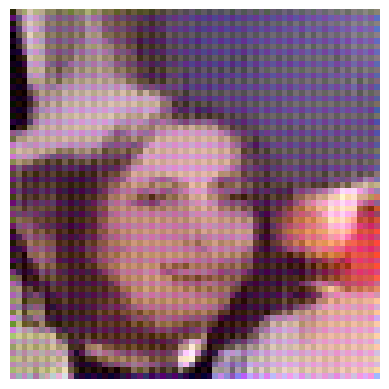

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


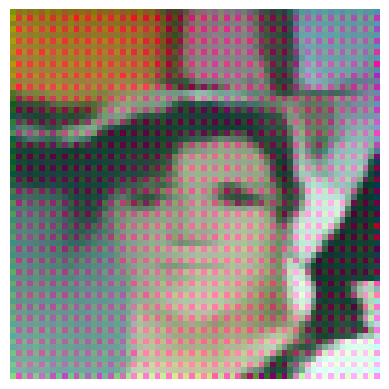

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


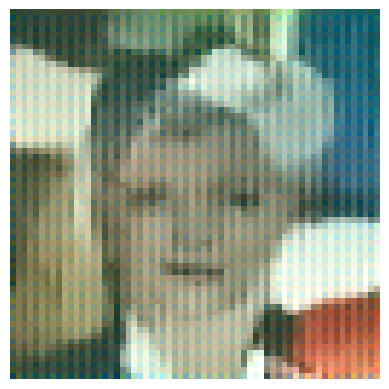

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


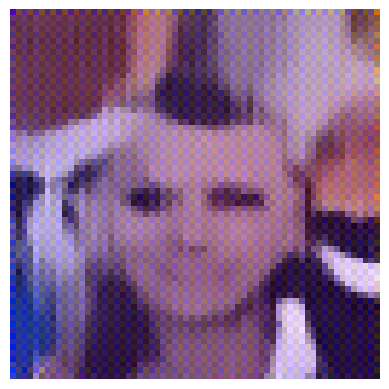

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


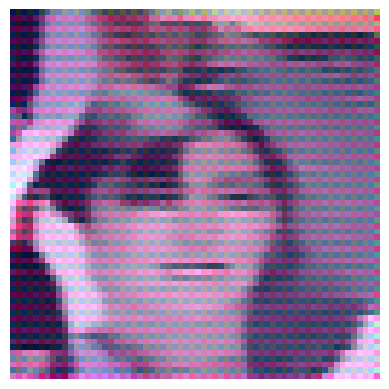

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


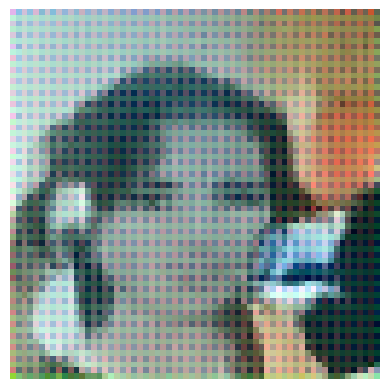

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


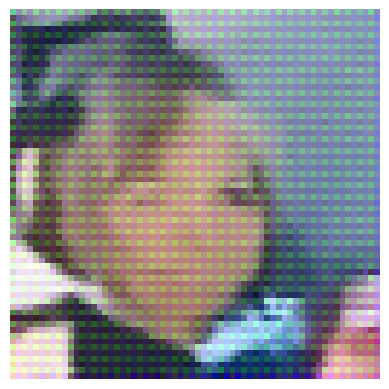

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


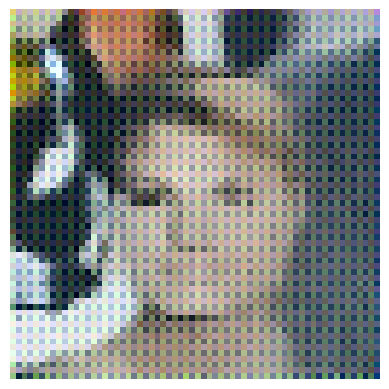

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


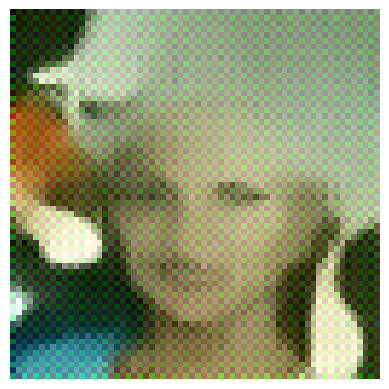

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


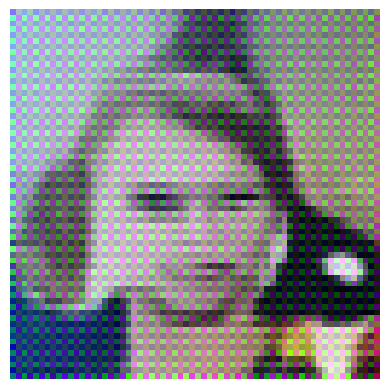

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


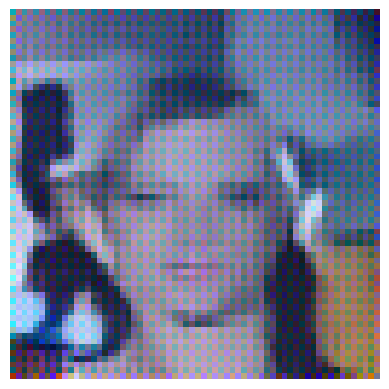

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


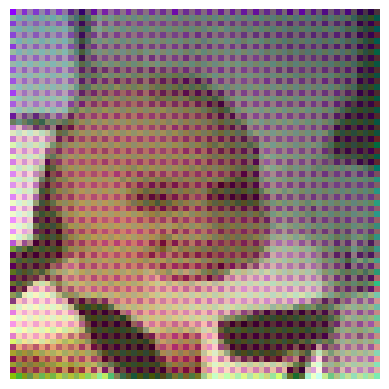

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


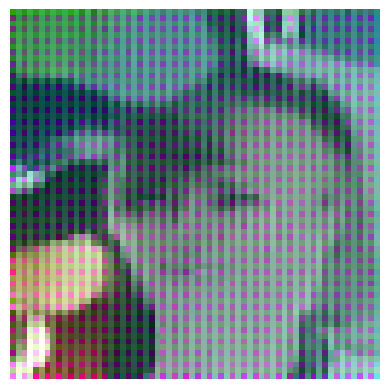

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


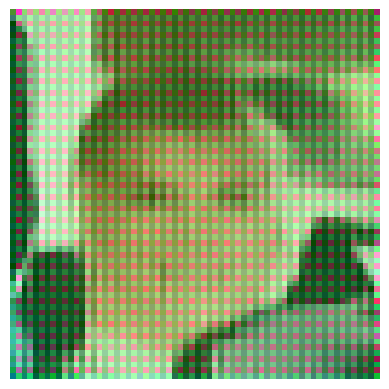

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


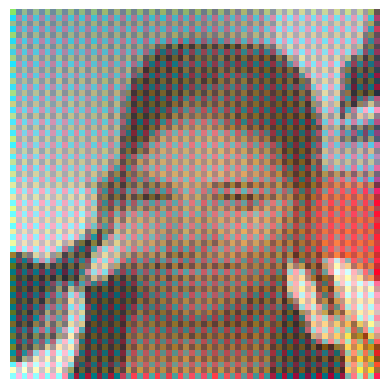

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


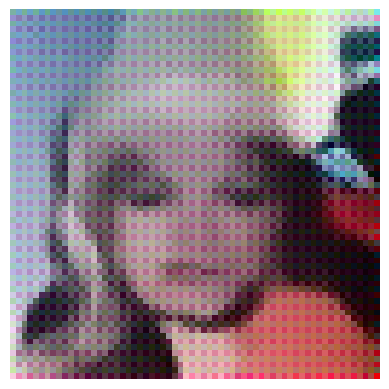

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


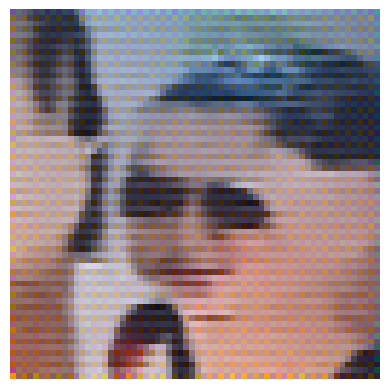

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


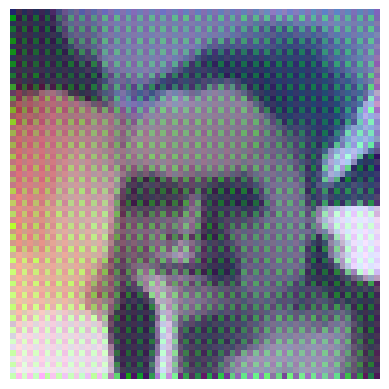

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


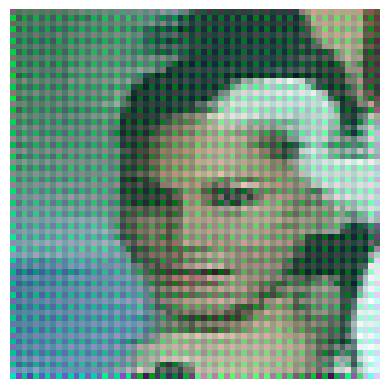

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


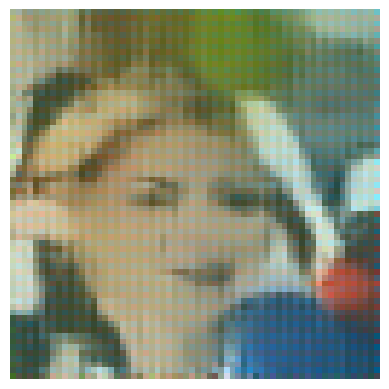

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


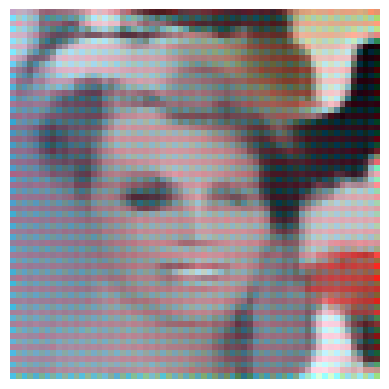

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


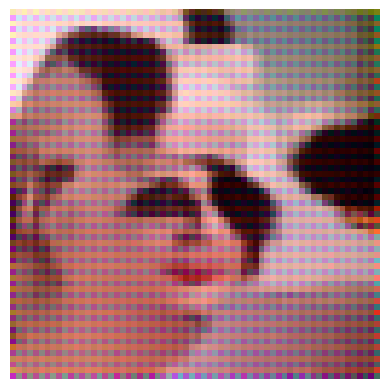

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


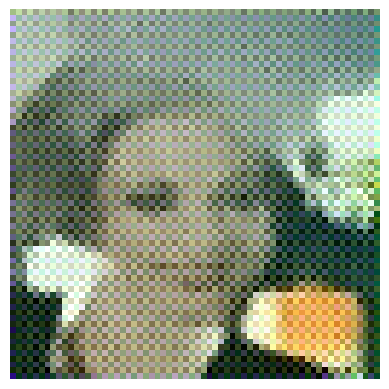

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


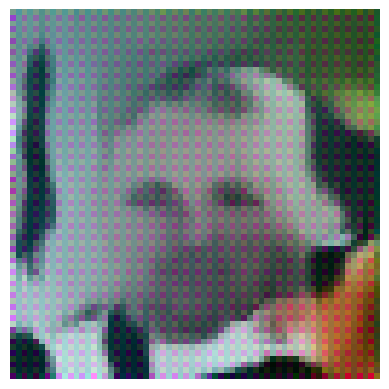

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


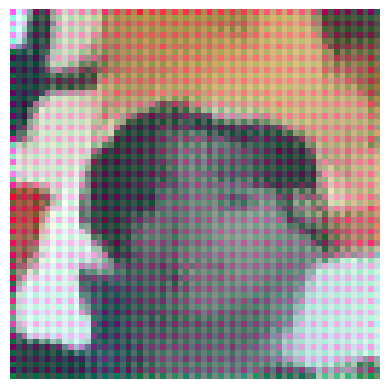

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


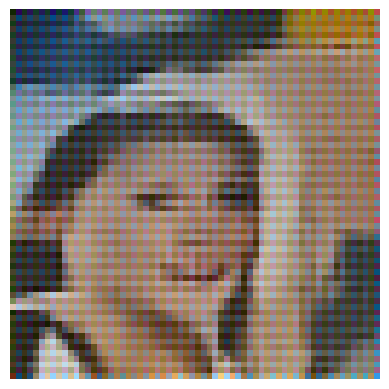

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


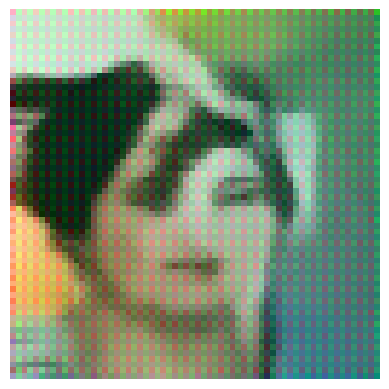

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


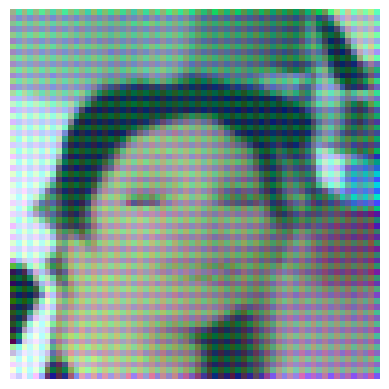

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


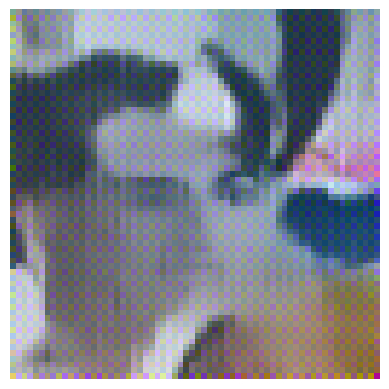

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


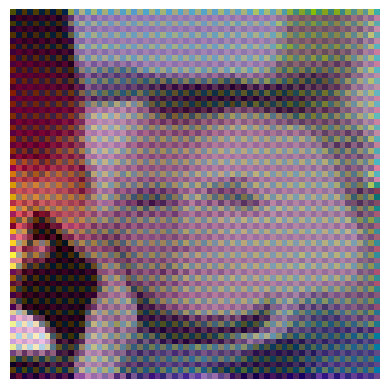

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


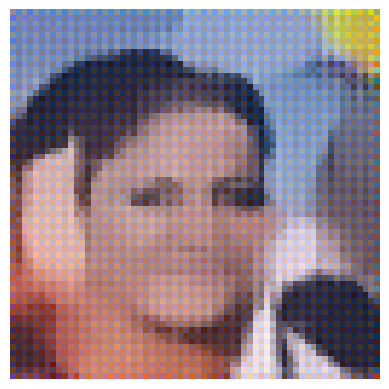

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


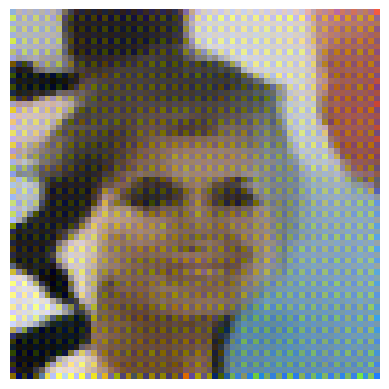

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


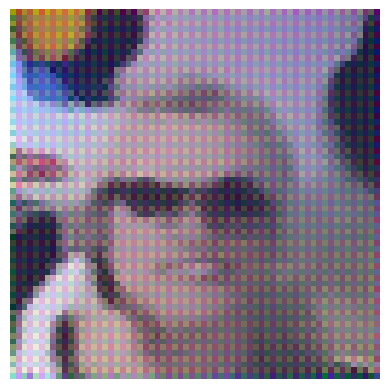

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


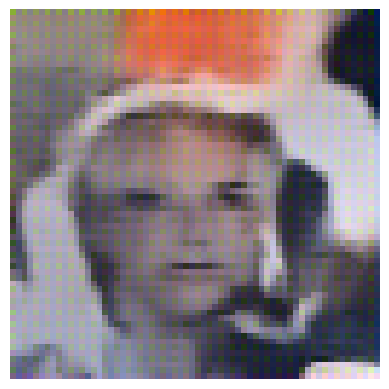

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


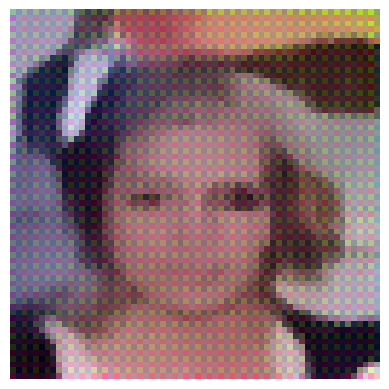

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


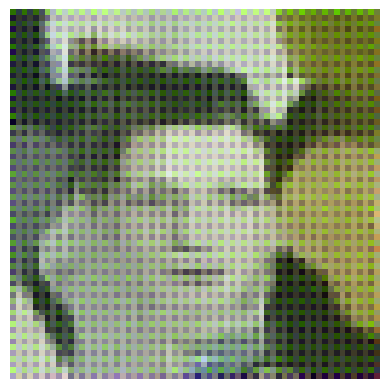

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


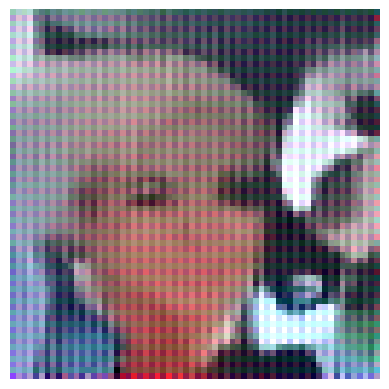

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


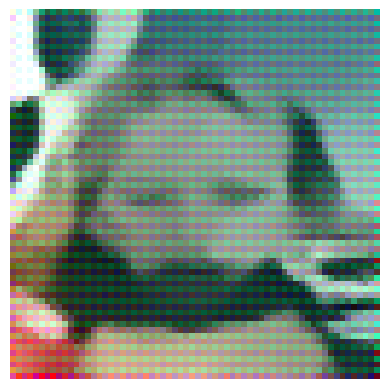

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


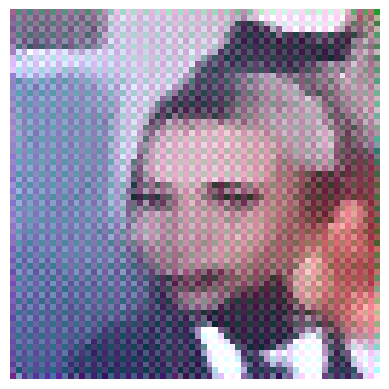

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


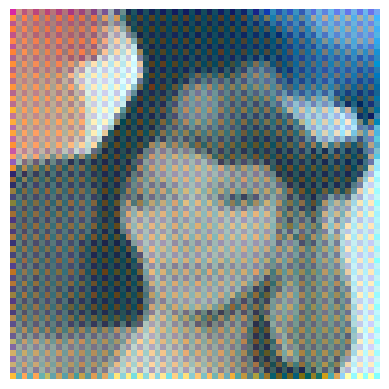

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


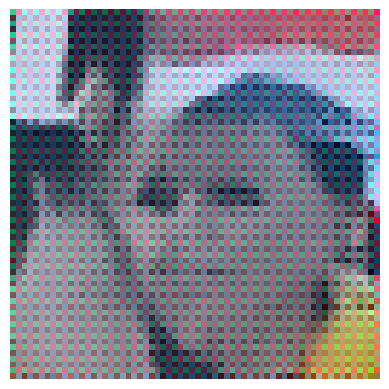

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


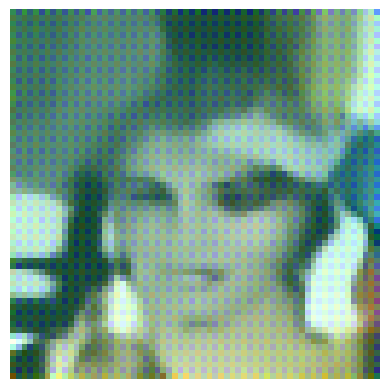

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


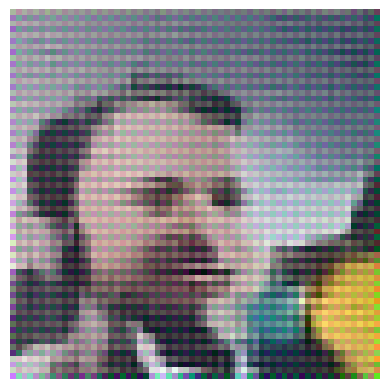

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


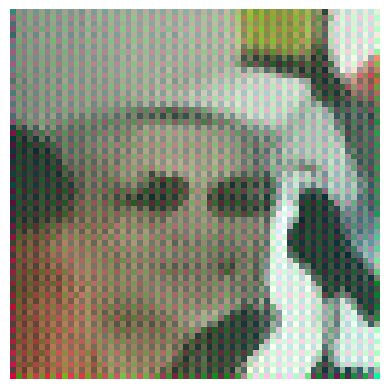

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


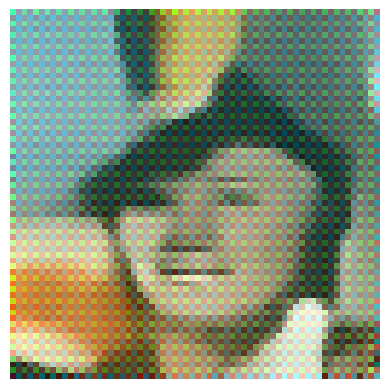

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


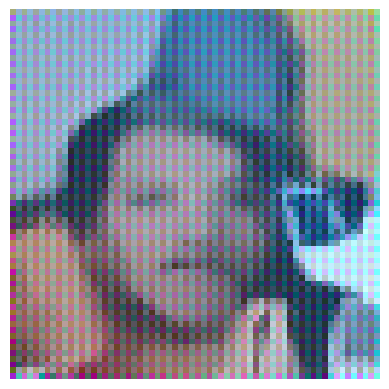

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


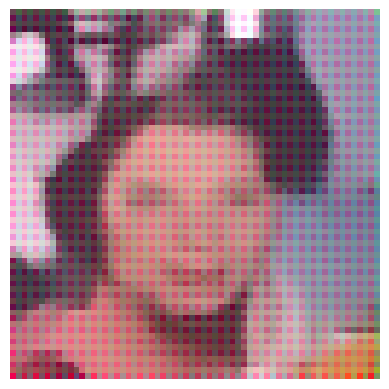

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


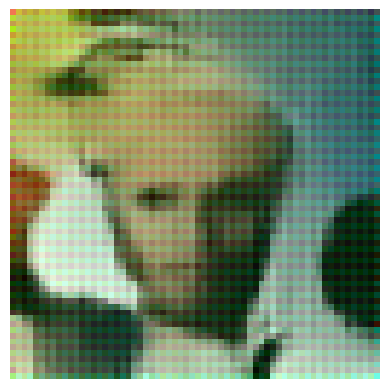

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


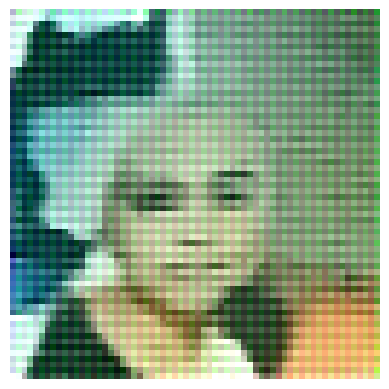

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


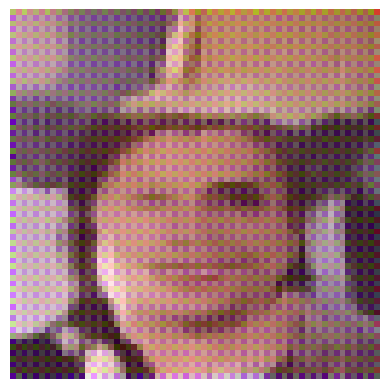

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


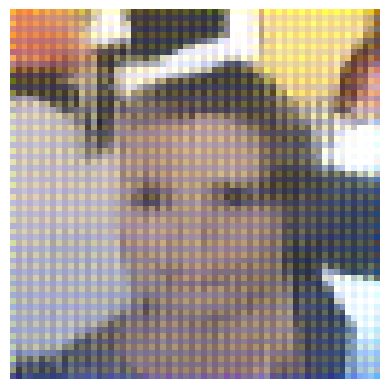

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


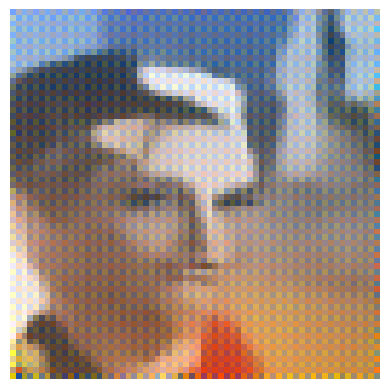

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


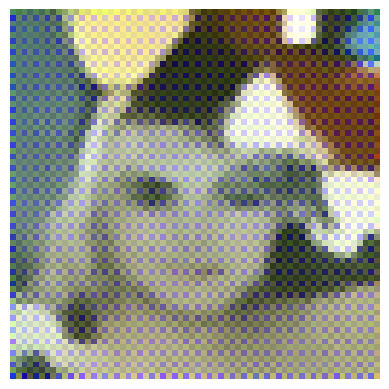

In [28]:
for _ in range(64):
    images = p_x0_xT(T).cpu()
    images = (images*0.5)+0.5  # Undo normalization
    image = images[0]
    image = image.squeeze().permute(1, 2, 0)
    plt.imshow(image)
    plt.axis('off')
    plt.savefig(f"Generated Images/Generated Image {_}.png", bbox_inches='tight', pad_inches=0)
    plt.show()